<h1 align="center" style="font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; color: #2c3e50;">
    OBSERVATÓRIO DA COMUNIDADE CIENTÍFICA DA UNIVERSIDADE DE AVEIRO
</h1>
<h1 align="center">Introdução à Ciência de Dados</h1>

**Equipa de Trabalho**
| Nº Mecanográfico | Nome do Estudante |
| :--- | :--- |
| **129253** | Anna Paula Barros da Silva |
| **130542** | Rebeca Gomes de Freitas |
| **130557** | Vitória da Conceição Rodrigues |

<br>

Este notebook apresenta uma análise de Inteligência Bibliométrica sobre a produção científica da UA. 
O objetivo é integrar métricas quantitativas (como total de citações e evolução temporal) com algoritmos avançados de **Processamento de Linguagem Natural (NLP)**. Isso permite descobrir tópicos latentes, identificar padrões de colaboração e transformar dados brutos em conhecimento estratégico para a instituição.

---

# Importação de bibliotecas
> Configuração do ambiente de desenvolvimento: carregamento de pacotes essenciais para manipulação de dados (Pandas), visualização (Plotly/Matplotlib) e processamento de linguagem natural (NLTK/Spacy).

In [1]:
# Sistema e Avisos
import os
import sys
import warnings
from pathlib import Path

# Manipulação e Análise de Dados
import pandas as pd
import numpy as np
import json
import re  
from collections import Counter
from itertools import combinations

# Visualização de Dados
import matplotlib.pyplot as plt

# Processamento de Texto (NLP) e Machine Learning
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF  
from sklearn.manifold import TSNE     

# Utilitários Diversos
import requests 
import textwrap 
from tqdm import tqdm  

# Configuração de Reprodutibilidade 
RANDOM_STATE = 42

# Dataset e Configuração

### Limpeza dos dados 
Como houve problema com a chave API, o data set foi baixado diretamente do site Scopus da Universidade de Aveiro, gerando o dataset com nome de "ScopusUA" que consta na pasta "data".

### Configuração do ambiente

In [2]:
# Configuração de Caminhos
def find_project_root(marker="README.md"):
    current_dir = Path.cwd()
    while current_dir != current_dir.parent:
        if (current_dir / marker).exists():
            return current_dir
        current_dir = current_dir.parent
    raise FileNotFoundError(f"Marcador '{marker}' não encontrado nos diretórios acima.")

# Execução da Configuração 
try:
    project_root = find_project_root()
    sys.path.append(str(project_root))
    os.chdir(project_root)
    print(f"Diretório encontrado: {project_root}")
    
    file_path = project_root / "data" / "scopusUA.csv"
    
    df = pd.read_csv(file_path)
    
    print(f"Dataset carregado com sucesso: {df.shape[0]} registos.")
    
except Exception as e:
    print(f"ERRO CRÍTICO: {e}")
    print("Verifique se o arquivo 'README.md' está na raiz e 'data/scopusUA.csv' existe.")

Diretório encontrado: c:\Users\rodri\Documents\1semestre\ICD\Milestone3ICD
Dataset carregado com sucesso: 5000 registos.


# <span style="color:#2980b9"> Parte 1: Análise Bibliométrica </span>

> Exploração quantitativa dos metadados extraídos do Scopus. Esta secção foca na análise descritiva, mapeando a evolução temporal das publicações, a distribuição geográfica da investigação e a identificação dos principais autores e fontes influentes. 

### <span style="color:#2980b9">1. Carregamento e Limpeza Inicial dos Dados</span>

In [3]:
print("--- Visão Geral dos Dados Bibliométricos ---")
print(df.head(2))
print(f"\nColunas disponíveis: \n{list(df.columns)}")

# Ver as primeiras linhas e os nomes das colunas
print(df.head(2))
print(df.columns)

--- Visão Geral dos Dados Bibliométricos ---
                                             Authors  \
0  Correia, P.D.; de Sousa, B.M.; Chato-Astrain, ...   
1                     Fernandes, M.E.; Piedade, C.A.   

                                   Author full names  \
0  Correia, Patrícia D. (57205681241); de Sousa, ...   
1  Fernandes, Maria Elisa (36643662100); Piedade,...   

                                        Author(s) ID  \
0  57205681241; 58725413600; 57203317900; 5999764...   
1                           36643662100; 57202900179   

                                               Title  Year  \
0  Injury-induced KIF4A neural expression and its...  2026   
1  Regular polytopes of rank n/2 for transitive g...  2026   

                   Source title Volume Issue Art. No. Page start  ... ISBN  \
0  Neural Regeneration Research     21     4      NaN       1607  ...  NaN   
1            Journal of Algebra    689   NaN      NaN        256  ...  NaN   

   CODEN  PubMed ID Langua

### <span style="color:#2980b9">2. Quantos?</span>
>Nesta seção, analisamos contagens, como o número de artigos, citações, autores e outras métricas semelhantes.

In [4]:
# ------------------------------------ CONTAGENS SIMPLES

# Total de artigos
total_articles = df.shape[0]
print(f"Número total de artigos: {total_articles}")

# Artigos mais citaddos
top_cited_articles = df[['Title', 'Cited by']].sort_values(by='Cited by', ascending=False).head(10)
print("\n\nTop 10 artigos mais citados:")
print(top_cited_articles)

# Autores mais produtivos
author_counts = (
    df['Author full names']
    .fillna('')
    .str.split(';')                    
    .explode()                         
    .str.strip()                       
    .apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))   
    .apply(lambda x: f"{x.split(',')[1].strip()} {x.split(',')[0].strip()}" if ',' in x else x) 
    .value_counts()
    .head(10)
)

print("\n\nTop 10 Autores mais produtivos:")
print(author_counts)

Número total de artigos: 5000


Top 10 artigos mais citados:
                                                  Title  Cited by
4805  Guidelines for the use and interpretation of a...      1981
3352  New insights into the genetic etiology of Alzh...      1329
2030  GWTC-3: Compact Binary Coalescences Observed b...      1033
2780  Population of Merging Compact Binaries Inferre...       680
4167  Optical fiber sensing for marine environment a...       407
4087  Green iot and edge AI as key technological ena...       309
1452  GWTC-2.1: Deep extended catalog of compact bin...       299
4003  Critical Review: Role of Inorganic Nanoparticl...       280
2069  Spotlight on Luminescence Thermometry: Basics,...       269
2342  The Rising Threat of Atmospheric CO2: A Review...       268


Top 10 Autores mais produtivos:
Author full names
Fernando Joaquim Lopes Moreira    117
N. Borges De Borges Carvalho       98
Carlos A.R. Herdeiro               79
Rui Luís Aguiar                    78
Susana Sa

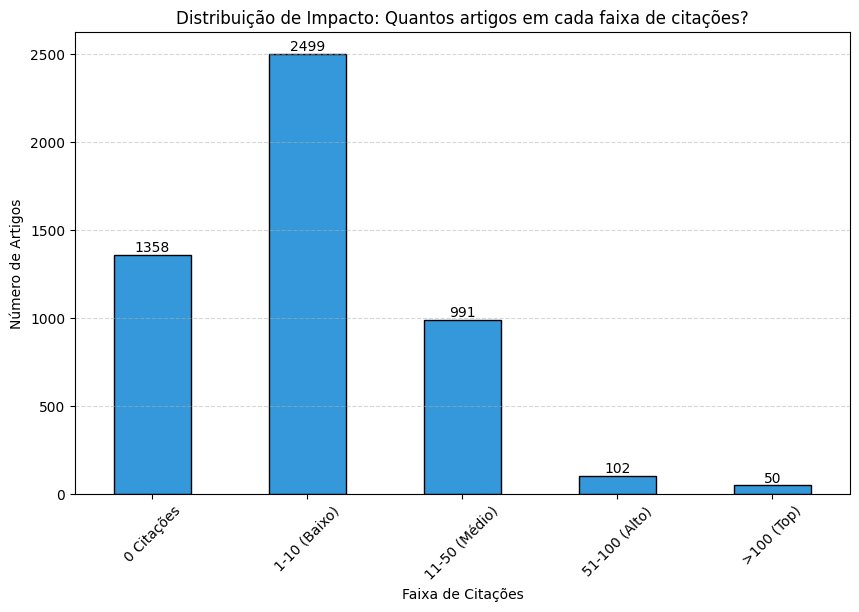

In [5]:
# ---------------------------------- DSITRIBUIÇÃO DE CITAÇÕES 

# 1. Criar faixas de citações
bins = [-1, 0, 10, 50, 100, 50000]
labels = ['0 Citações', '1-10 (Baixo)', '11-50 (Médio)', '51-100 (Alto)', '>100 (Top)']

# Criar coluna com as faixas
df['Citation_Range'] = pd.cut(df['Cited by'].fillna(0), bins=bins, labels=labels)

# 2. Contar e ordenar
citation_counts = df['Citation_Range'].value_counts().sort_index()

# 3. Gráfico de Barras
plt.figure(figsize=(10, 6))
bars = citation_counts.plot(kind='bar', color='#3498db', edgecolor='black')

plt.title("Distribuição de Impacto: Quantos artigos em cada faixa de citações?")
plt.xlabel("Faixa de Citações")
plt.ylabel("Número de Artigos")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adicionar os números em cima das barras
for container in bars.containers:
    bars.bar_label(container)

plt.show()

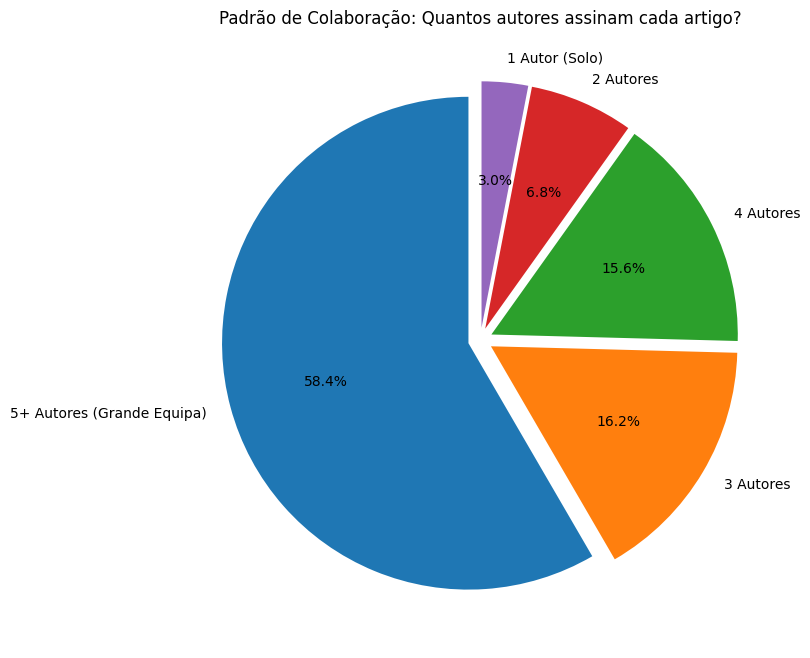

Média de autores por artigo: 21.02


In [6]:
# ---------------------------- COLABORAÇÃO ENTRE AUTORES

# 1. Calcular o número de autores por artigo 
df['num_authors'] = df['Author full names'].fillna('').str.count(';') + 1

# 2. Criar categorias para facilitar a visualização
def categorize_authors(n):
    if n == 1: return '1 Autor (Solo)'
    elif n == 2: return '2 Autores'
    elif n == 3: return '3 Autores'
    elif n == 4: return '4 Autores'
    elif n >= 5: return '5+ Autores (Grande Equipa)'
    return 'Desconhecido'

df['Collab_Type'] = df['num_authors'].apply(categorize_authors)

# 3. Visualizar
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
df['Collab_Type'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    startangle=90, 
    explode=(0.05, 0.05, 0.05, 0.05, 0.05) # Destacar as fatias levemente
)
plt.title("Padrão de Colaboração: Quantos autores assinam cada artigo?")
plt.ylabel('') # Remover label do eixo Y para ficar mais limpo
plt.show()

print(f"Média de autores por artigo: {df['num_authors'].mean():.2f}")

### <span style="color:#2980b9">3. Quem?</span>
> Esta parte se concentrará em aspectos temporais, analisando tendências ao longo do tempo. Por exemplo, quantos artigos foram publicados a cada ano.

Tendências de publicação anual:


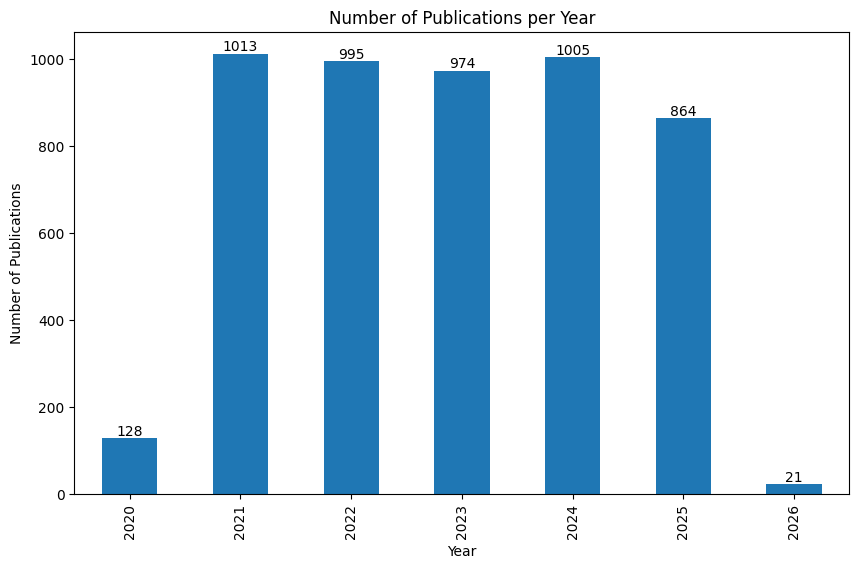

In [7]:
# Tendências de publicação anual
yearly_publications = df['Year'].value_counts().sort_index()
print("Tendências de publicação anual:")

plt.figure(figsize=(10, 6))
ax = yearly_publications.plot(kind='bar', title='Number of Publications per Year')
plt.xlabel("Year")
plt.ylabel("Number of Publications")

# Add labels on top of each bar
ax.bar_label(ax.containers[0])

plt.show()

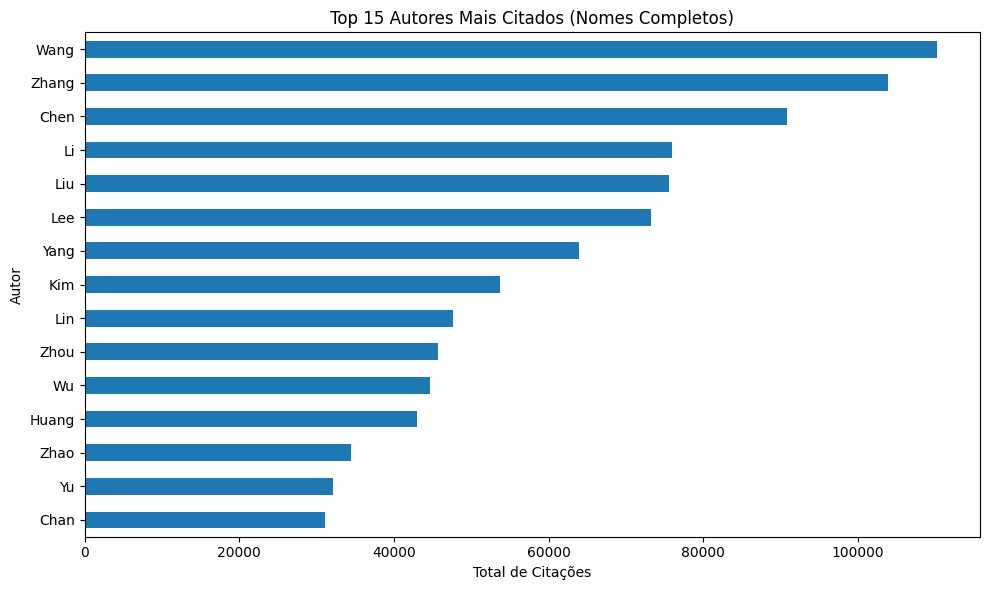

In [8]:
# Autores mais citados 

col_authors = "Author full names" if "Author full names" in df.columns else "Authors"
col_cited = "Cited by"

if col_authors in df.columns and col_cited in df.columns:
    authors_citations = (
        df[[col_authors, col_cited]]
        .dropna()
        .assign(**{col_authors: df[col_authors].astype(str)})
    )

    authors_citations[col_authors] = (
        authors_citations[col_authors]
        .str.replace(r'\s+and\s+', ',', regex=True)
        .str.replace(';', ',', regex=False)
    )

    authors_citations = (
        authors_citations
        .assign(author=authors_citations[col_authors].str.split(','))
        .explode('author')
    )

    authors_citations['author'] = authors_citations['author'].str.strip()
    authors_citations = authors_citations[authors_citations['author'] != ""]

    top_cited_authors = (
        authors_citations.groupby('author')[col_cited].sum()
        .sort_values(ascending=False)
        .head(15)
    )

    
    # Gráfico
    plt.figure(figsize=(10, 6))
    top_cited_authors.sort_values().plot(kind='barh')
    plt.title("Top 15 Autores Mais Citados (Nomes Completos)")
    plt.xlabel("Total de Citações")
    plt.ylabel("Autor")
    plt.tight_layout()
    plt.show()

else:
    print("Colunas de autores ou citações não encontradas no dataset.")


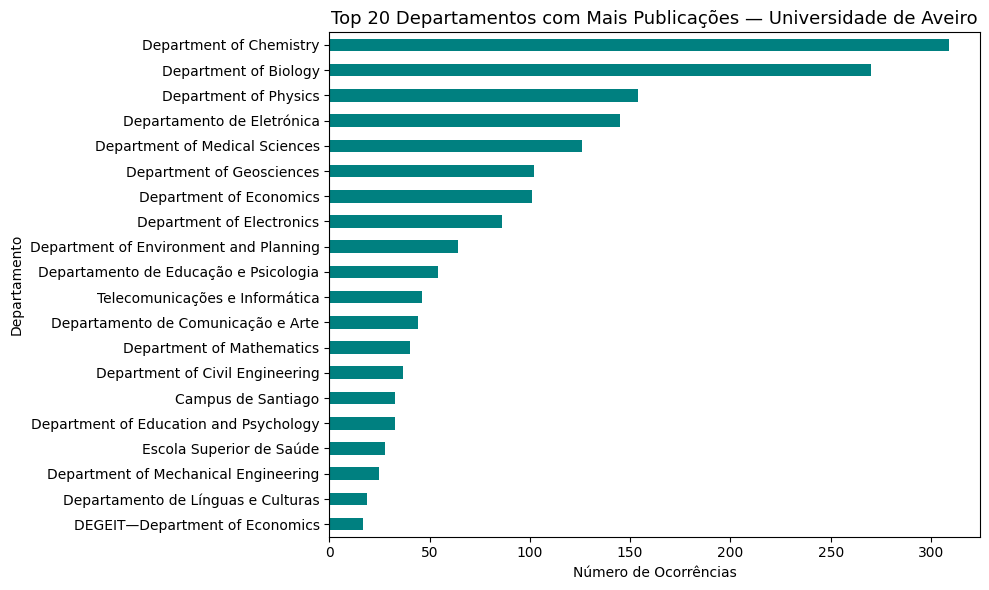

In [9]:
# Filtra apenas as linhas com "Universidade de Aveiro" na afiliação
ua_affils = df["Affiliations"].dropna().astype(str)
ua_affils = ua_affils[ua_affils.str.contains("Universidade de Aveiro", case=False, na=False)]

# Extrai o texto ANTES de ", Universidade de Aveiro"
def extract_department(text):
    match = re.search(r"([^,;]+),\s*Universidade de Aveiro", text, flags=re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None

# Aplica a função a cada afiliação (mesmo quando há vários separados por ;)
departments = (
    ua_affils
    .str.split(";")
    .explode()
    .dropna()
    .apply(extract_department)
    .dropna()
)

# Conta as ocorrências de cada departamento
top_departments = departments.value_counts().head(20)

# === Gráfico ===
plt.figure(figsize=(10, 6))
top_departments.sort_values().plot(kind="barh", color="teal")
plt.title("Top 20 Departamentos com Mais Publicações — Universidade de Aveiro", fontsize=13)
plt.xlabel("Número de Ocorrências")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


### <span style="color:#2980b9">4. Onde?</span>
> Esta seção examinará onde a pesquisa foi publicada, analisando periódicos, conferências e afiliações.

In [10]:
# Revistas mais citadas
# Responde à pergunta: Onde publicamos com mais sucesso? (Impacto/Citações)
journal_citations = df.groupby('Source title')['Cited by'].sum().sort_values(ascending=False).head(10)
print("Top 10 Revistas mais citadas:")
print(journal_citations.to_string())


Top 10 Revistas mais citadas:
Source title
Autophagy                           1981
Physical Review X                   1741
Physical Review D                   1701
Nature Genetics                     1329
Science of the Total Environment    1071
Sensors                              985
Physical Review Letters              743
Scientific Reports                   682
Sustainability (Switzerland)         655
IEEE Sensors Journal                 610


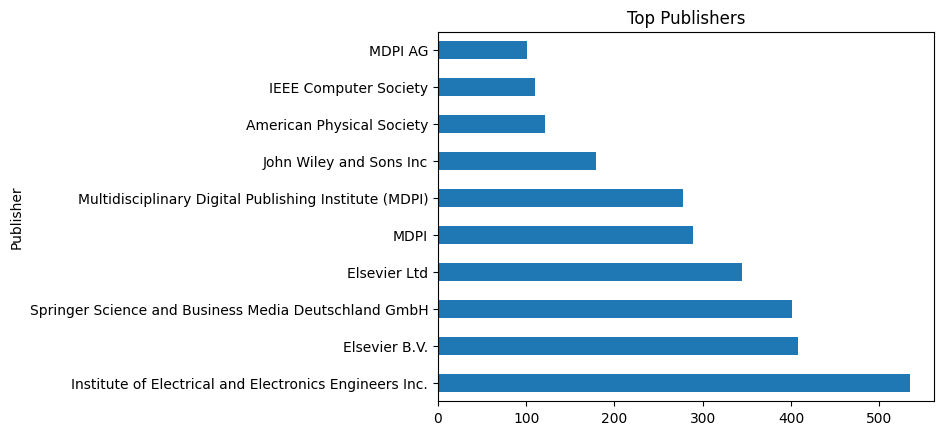

Top Países Colaboradores:
Country_Extracted
Portugal          3444
Brazil             485
Spain              240
United States       80
United Kingdom      65
India               62
Italy               59
Germany             53
China               52
Pakistan            45
France              38
Colombia            30
Chile               25
Tunisia             19
Poland              16
Name: count, dtype: int64


In [11]:
# Principais Editoras 
# Responde à pergunta: Onde publicamos mais? (Volume)
df['Publisher'].value_counts().head(10).plot(kind='barh', title='Top Publishers')
plt.show()

# Países Colaboradores (extraindo da Afiliação)
# Nota: Isto assume que o país é a última parte da string de afiliação após uma vírgula
def extract_country(text):
    if pd.isna(text): return None
    # Pega a afiliação, divide por ponto e vírgula (se houver várias), pega a primeira
    first_aff = text.split(';')[0]
    # Pega a última parte após a vírgula (geralmente o país)
    return first_aff.split(',')[-1].strip()

df['Country_Extracted'] = df['Affiliations'].apply(extract_country)
print("Top Países Colaboradores:")
print(df['Country_Extracted'].value_counts().head(15))

### <span style="color:#2980b9">4. O que?</span>
> Nesta seção final, você analisará os tópicos e temas da pesquisa, como palavras-chave, conteúdo do resumo e fontes de financiamento. 


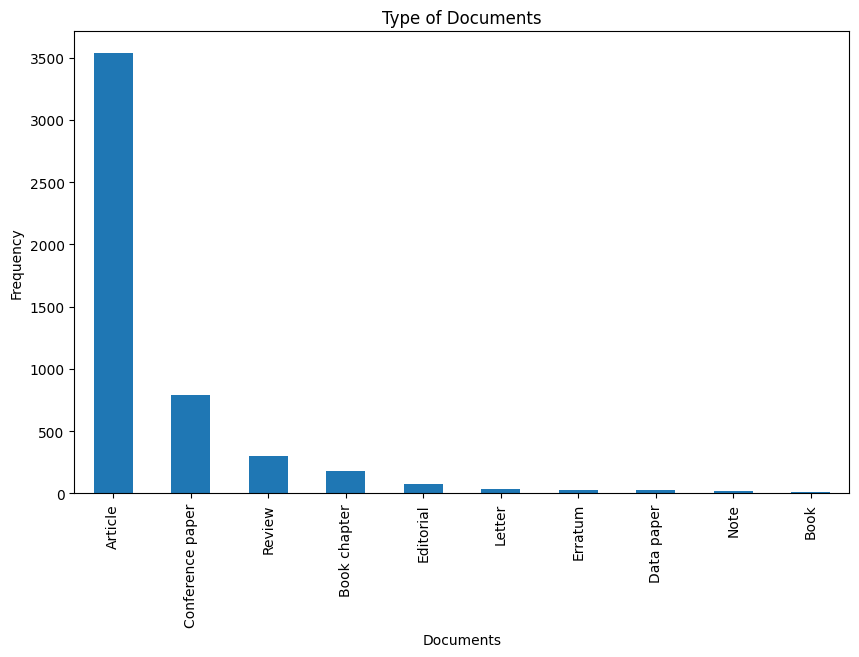

In [12]:
# Documentos mais frequentes
df['Document Type'] = df['Document Type'].fillna('')
all_keywords = df['Document Type'].str.split('; ').explode().value_counts().head(10)

# Plot 
plt.figure(figsize=(10, 6))
all_keywords.plot(kind='bar', title='Type of Documents')
plt.xlabel("Documents")
plt.ylabel("Frequency")
plt.show()

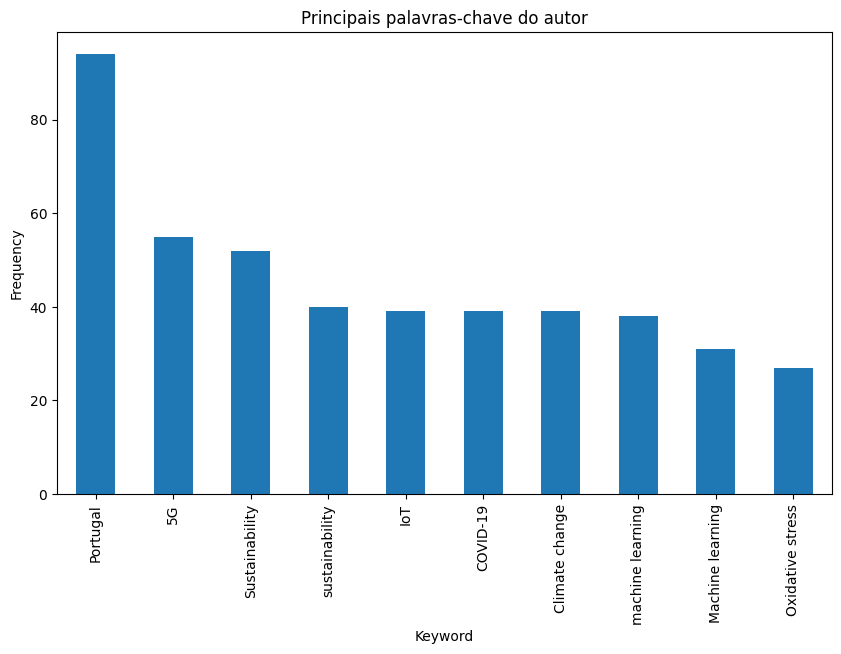

In [13]:
# Palavras-chave mais frequentes
# 1. Preenche nulos e separa as palavras
df['Author Keywords'] = df['Author Keywords'].fillna('')
keywords_series = df['Author Keywords'].str.split('; ').explode()

# 2. FILTRO: Remove strings vazias ou espaços em branco
keywords_series = keywords_series[keywords_series.str.strip() != '']

# 3. Conta e pega o Top 10
all_keywords = keywords_series.value_counts().head(10)

# 4. Plota
plt.figure(figsize=(10, 6))
all_keywords.plot(kind='bar', title='Principais palavras-chave do autor')
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.show()


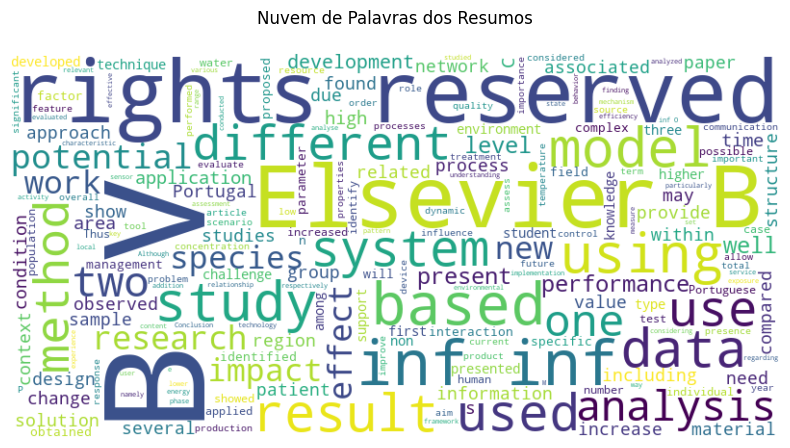

In [14]:
#  Word Cloud dos Abstracts (Visualização Rápida) 
from wordcloud import WordCloud

text = " ".join(review for review in df.Abstract.dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras dos Resumos\n")
plt.show()

# <span style="color:#27ae60">Parte 2: Análise de Conteúdo (NLP)</span>
> Processamento semântico e mineração textual dos resumos (abstracts). Aplicam-se técnicas de NLP para limpeza textual e modelação de tópicos (Topic Modeling), permitindo descobrir os temas latentes e as tendências concetuais da área. <

### <span style="color:#27ae60">1. Carregamento e Limpeza Inicial dos Dados</span>
Carregamento do dataset `scopusUA.csv`. Remoção de artigos sem Abstract.

In [15]:
# Preparação Específica para NLP
dfscopusCleaned = df.dropna(subset=['Abstract']).copy().reset_index(drop=True)

# 2. Criar ID único sequencial (útil para o Power BI depois)
dfscopusCleaned['Article_ID'] = range(1, len(dfscopusCleaned) + 1)

print(f"Dataset original: {df.shape[0]} registos.")
print(f"Dataset para NLP (sem abstracts nulos): {dfscopusCleaned.shape[0]} registos.")

Dataset original: 5000 registos.
Dataset para NLP (sem abstracts nulos): 5000 registos.


### <span style="color:#27ae60">2. Pré-processamento com spaCy</span>
Utilização do pipeline do `spaCy` para: Tokenização, Remoção de Stopwords e Pontuação, Filtragem gramatical (apenas Substantivos, Nomes Próprios e Adjetivos), Lematização 

In [16]:
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    print("Modelo spaCy carregado.")
except OSError:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Função de limpeza
def spacy_preprocess(text):
    doc = nlp(str(text))
    tokens = []
    allowed_postags = {"NOUN", "PROPN", "ADJ"} 
    
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space:
            continue
        if token.pos_ in allowed_postags and len(token.lemma_) > 2:
            tokens.append(token.lemma_.lower())
            
    return " ".join(tokens)

dfscopusCleaned["spacy_clean"] = dfscopusCleaned["Abstract"].apply(spacy_preprocess)
print("Pré-processamento concluído.")

Modelo spaCy carregado.
Pré-processamento concluído.


### <span style="color:#27ae60">3. Modelagem de Tópicos (NMF)</span>
Extração de tópicos latentes usando **Non-Negative Matrix Factorization (NMF)** sobre uma matriz **TF-IDF**.
O NMF foi escolhido pela sua capacidade de gerar tópicos mais coerentes e interpretáveis em textos curtos.

In [17]:
# 1. Vetorização TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.85,
    ngram_range=(1, 2) 
)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfscopusCleaned["spacy_clean"])

# 2. Treino do Modelo NMF
n_topics = 10 
nmf_model = NMF(
    n_components=n_topics,
    random_state=RANDOM_STATE,
    init='nndsvd'
)
nmf_doc_topic = nmf_model.fit_transform(tfidf_matrix)

# 3. Tópico Dominante a cada Artigo
dfscopusCleaned["Topic_ID"] = nmf_doc_topic.argmax(axis=1)

print(f"Modelo treinado com {n_topics} tópicos.")

Modelo treinado com 10 tópicos.


### <span style="color:#27ae60">4. Enriquecimento Semântico com LLM (Ollama)</span> 
Utilização de um modelo local (Llama 3.2 via Docker/Ollama) para gerar títulos e descrições automáticas para cada tópico identificado matematicamente.

In [18]:
# Configuração
OLLAMA_URL = "http://localhost:11434/api/chat"
OLLAMA_MODEL = "llama3.2"

def generate_topic_summary(topic_idx, top_terms, sample_abstracts):
    prompt = f"""
    You are a scientific assistant. Analyze the following Topic {topic_idx} derived from academic papers.
    
    Keywords: {', '.join(top_terms)}
    
    Sample Abstracts:
    1. {sample_abstracts[0][:300]}...
    2. {sample_abstracts[1][:300]}...
    
    Task:
    1. Provide a short Label (max 5 words).
    2. Write a Summary (3-4 sentences) explaining the research theme.
    
    Format output as JSON: {{"label": "...", "summary": "..."}}
    """
    
    payload = {
        "model": OLLAMA_MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "stream": False,
        "format": "json" 
    }
    
    try:
        response = requests.post(OLLAMA_URL, json=payload)
        response.raise_for_status()
        return response.json()['message']['content']
    except Exception as e:
        return json.dumps({"label": f"Topic {topic_idx}", "summary": "Summary unavailable."})

# Preparar dados e chamar LLM
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_summaries = {}

print("A gerar resumos com IA (Certifique-se que o Docker/Ollama está funcionando)...")

for topic_idx, topic in enumerate(nmf_model.components_):
    # Top palavras
    top_indices = topic.argsort()[::-1][:10]
    top_terms = [feature_names[i] for i in top_indices]
    
    # Top abstracts
    top_doc_indices = np.argsort(-nmf_doc_topic[:, topic_idx])[:2]
    sample_docs = dfscopusCleaned.iloc[top_doc_indices]["Abstract"].tolist()
    
    # Chamada LLM
    json_res = generate_topic_summary(topic_idx, top_terms, sample_docs)
    topic_summaries[topic_idx] = json.loads(json_res)
    print(f"Tópico {topic_idx} processado.")

A gerar resumos com IA (Certifique-se que o Docker/Ollama está funcionando)...
Tópico 0 processado.
Tópico 1 processado.
Tópico 2 processado.
Tópico 3 processado.
Tópico 4 processado.
Tópico 5 processado.
Tópico 6 processado.
Tópico 7 processado.
Tópico 8 processado.
Tópico 9 processado.


### <span style="color:#27ae60">5. Extração de Conhecimento e Mapa de Ciência</span>

Nesta etapa, realizamos o processamento avançado para extrair três tipos de metadados essenciais para o Dashboard:

1.  **Geografia (NER):** Utilizamos o modelo `spaCy` para identificar Entidades Geopolíticas (GPE) nos abstracts, permitindo mapear os países e regiões mencionados nos estudos.  
2.  **Autores e Redes:** Processamos a coluna de autores para separar nomes individuais, gerar IDs únicos (via *hashing*) e criar as tabelas de dimensão e ponte necessárias para analisar redes de colaboração.  
3.  **Mapa de Ciência (t-SNE):** Aplicamos o algoritmo **t-SNE** sobre a matriz TF-IDF para reduzir a alta dimensionalidade do texto em apenas 2 coordenadas (X e Y). Isso permitirá visualizar a proximidade semântica entre artigos num gráfico de dispersão.



In [19]:
nlp_ner = spacy.load("en_core_web_sm")

geo_data = []
authors_data = []
bridge_authors = []
author_seen = set()

for idx, row in tqdm(dfscopusCleaned.iterrows(), total=dfscopusCleaned.shape[0]):
    art_id = row['Article_ID']
    
    # 1. Geografia (GPE)
    doc = nlp_ner(str(row['Abstract']))
    seen_countries = set()
    for ent in doc.ents:
        if ent.label_ == 'GPE':
            clean_geo = ent.text.strip()
            if clean_geo not in seen_countries:
                geo_data.append({"Article_ID": art_id, "Country_Region": clean_geo})
                seen_countries.add(clean_geo)
                
    # 2. Autores
    if not pd.isna(row['Authors']):
        names = str(row['Authors']).split(',')
        
        for name in names:
            clean_name = name.strip()
            if not clean_name: continue
            auth_id = hash(clean_name) 
            
            bridge_authors.append({"Article_ID": art_id, "Author_ID": auth_id})
            
            if auth_id not in author_seen:
                authors_data.append({"Author_ID": auth_id, "Author_Name": clean_name})
                author_seen.add(auth_id)


# 3. Mapa de Ciência (t-SNE)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init='random')
coords = tsne.fit_transform(tfidf_matrix)
df_coords = pd.DataFrame({
    "Article_ID": dfscopusCleaned['Article_ID'],
    "Coord_X": coords[:, 0],
    "Coord_Y": coords[:, 1]
})

100%|██████████| 5000/5000 [08:40<00:00,  9.60it/s]


### <span style="color:#27ae60">6. Redes de colaboração entre autores</span> 

Este código cria uma tabela de "Arestas" (Edges) que diz: Autor A trabalhou com Autor B, X vezes.

In [20]:
# Cálculos Analíticos Avançados (Tendências e Redes)
from itertools import combinations
from collections import Counter
import pandas as pd # Garantir que o pandas está importado

print("--- A INICIAR CÁLCULOS AVANÇADOS ---")

# TENDÊNCIAS TEMPORAIS (HOT vs COLD TOPICS)
print("1. A calcular tendências (Hot/Cold)...")

trend_df = dfscopusCleaned.groupby(['Topic_ID', 'Year']).size().reset_index(name='Counts')

max_year = int(trend_df['Year'].max())
recent_years = [max_year, max_year-1, max_year-2]

topic_trends = {}
num_topics_range = range(nmf_model.n_components) 

for t_id in num_topics_range:
    data_t = trend_df[trend_df['Topic_ID'] == t_id]
    
    vol_recent = data_t[data_t['Year'].isin(recent_years)]['Counts'].sum()
    vol_total = data_t['Counts'].sum()
    
    if vol_total == 0:
        status = "❓ New/Undefined"
    else:
        ratio = vol_recent / vol_total
        if ratio > 0.40:
            status = "🔥 Hot / Emerging"
        elif ratio < 0.10:
            status = "❄️ Cold / Declining"
        else:
            status = "⚖️ Stable"
            
    topic_trends[t_id] = status

print("Classificação de tendências concluída.")

# REDE DE COLABORAÇÃO (CO-AUTORIA)
print("2. A calcular rede de co-autoria...")

author_pairs = []

for idx, row in dfscopusCleaned.iterrows():
    if pd.isna(row['Authors']):
        continue
        
    names = str(row['Authors']).split(',')
    # Cria IDs únicos (hash) para cada autor
    auth_ids = [hash(name.strip()) for name in names if name.strip()]
    
    if len(auth_ids) > 1:
        # Cria pares: (Autor A, Autor B)
        pairs = list(combinations(sorted(auth_ids), 2))
        author_pairs.extend(pairs)

pair_counts = Counter(author_pairs)

network_data = []
for (auth_a, auth_b), weight in pair_counts.items():
    network_data.append({
        "Source_Author_ID": auth_a,
        "Target_Author_ID": auth_b,
        "Weight": weight
    })

df_network = pd.DataFrame(network_data)

print(f"   Rede gerada na memória com {len(df_network)} conexões.")
print("--- CÁLCULOS PRONTOS PARA EXPORTAÇÃO ---")

--- A INICIAR CÁLCULOS AVANÇADOS ---
1. A calcular tendências (Hot/Cold)...
Classificação de tendências concluída.
2. A calcular rede de co-autoria...
   Rede gerada na memória com 18871421 conexões.
--- CÁLCULOS PRONTOS PARA EXPORTAÇÃO ---


# <span style="color:#833">Exportação de Dados para Power BI</span>
Geração dos ficheiros CSV finais para o Dashboard.

In [21]:
# EXPORTAÇÃO INTEGRADA (Bibliometria + NLP)

# Criar pasta de output 
os.makedirs("powerbi_data", exist_ok=True)
print("Pasta 'powerbi_data' preparada.")

# 1. TABELA DE FATOS PRINCIPAL (Artigos)
if 'Cited by' in dfscopusCleaned.columns:
    dfscopusCleaned['Cited by'] = dfscopusCleaned['Cited by'].fillna(0).astype(int)
else:
    dfscopusCleaned['Cited by'] = 0

# Selecionamos colunas essenciais. 
# Adicionamos 'Source title' (Revista) e 'Document Type' para filtros bibliométricos no Power BI
cols_to_export = ['Article_ID', 'Title', 'Year', 'Topic_ID', 'DOI', 'Link', 'Abstract', 'Cited by', 'Source title', 'Document Type']
# Verifica se as colunas existem antes de selecionar
cols_final = [c for c in cols_to_export if c in dfscopusCleaned.columns]

df_fact = dfscopusCleaned[cols_final].copy()
df_fact.to_csv("powerbi_data/Fact_Articles.csv", index=False, encoding='utf-8-sig')
print("Fact_Articles.csv gerado (Base principal).")

# 2. DIMENSÃO: TÓPICOS (NLP + LLM + Tendências)
topics_export = []
feature_names = tfidf_vectorizer.get_feature_names_out()

# Verificar se 'topic_trends' foi calculado, senão usa padrão
trends_data = topic_trends if 'topic_trends' in locals() else {}

for t_id, data in topic_summaries.items():
    # Recuperar top words do modelo NMF
    topic_vec = nmf_model.components_[t_id]
    top_idx = topic_vec.argsort()[::-1][:15]
    top_w = ", ".join([feature_names[i] for i in top_idx])
    
    # Recuperar tendência (Hot/Cold)
    trend = trends_data.get(t_id, "Not Calculated")

    topics_export.append({
        "Topic_ID": t_id,
        "Topic_Label": data.get("label", f"Topic {t_id}"),
        "Description": data.get("summary", "Sem resumo disponível."),
        "Top_Terms": top_w,
        "Trend_Status": trend  
    })

pd.DataFrame(topics_export).to_csv("powerbi_data/Dim_Topics.csv", index=False, encoding='utf-8-sig')
print("Dim_Topics.csv gerado (Inteligência Semântica).")

# 3. DIMENSÃO: GEOGRAFIA (Extraída com NER Spacy)
if 'geo_data' in locals() and geo_data:
    pd.DataFrame(geo_data).to_csv("powerbi_data/Bridge_Geography.csv", index=False, encoding='utf-8-sig')
    print("Bridge_Geography.csv gerado.")
else:
    print("geo_data vazio ou não definido. Pulando geografia.")

# 4. DIMENSÃO: AUTORES E REDES (Bibliometria)
if 'authors_data' in locals() and 'bridge_authors' in locals():
    pd.DataFrame(authors_data).to_csv("powerbi_data/Dim_Authors.csv", index=False, encoding='utf-8-sig')
    pd.DataFrame(bridge_authors).to_csv("powerbi_data/Bridge_Article_Authors.csv", index=False, encoding='utf-8-sig')
    print("Dim_Authors.csv e Bridge gerados.")
    
    # Opcional: Exportar a Rede de Co-autoria se foi calculada
    if 'df_network' in locals():
        df_network.to_csv("powerbi_data/Fact_CoAuthorship_Network.csv", index=False, encoding='utf-8-sig')
        print("Fact_CoAuthorship_Network.csv gerado (Para grafo de rede).")
else:
    print("Dados de autores não processados.")

# 5. TABELA AGREGADA: EVOLUÇÃO TEMPORAL (Para gráficos rápidos)
# Cria uma tabela leve apenas com contagens por Ano e Tópico
if 'Year' in dfscopusCleaned.columns and 'Topic_ID' in dfscopusCleaned.columns:
    df_timeline = dfscopusCleaned.groupby(['Year', 'Topic_ID']).size().reset_index(name='Article_Count')
    df_timeline.to_csv("powerbi_data/Agg_Timeline.csv", index=False, encoding='utf-8-sig')
    print("Agg_Timeline.csv gerado (Para gráficos de linha).")

# 6. MAPA DE CIÊNCIA (t-SNE Embeddings)
if 'df_coords' in locals():
    df_coords.to_csv("powerbi_data/Fact_ScienceMap.csv", index=False, encoding='utf-8-sig')
    print("Fact_ScienceMap.csv gerado.")

print("\n --- EXPORTAÇÃO TOTAL CONCLUÍDA! ---")

Pasta 'powerbi_data' preparada.


Fact_Articles.csv gerado (Base principal).
Dim_Topics.csv gerado (Inteligência Semântica).
Bridge_Geography.csv gerado.
Dim_Authors.csv e Bridge gerados.
Fact_CoAuthorship_Network.csv gerado (Para grafo de rede).
Agg_Timeline.csv gerado (Para gráficos de linha).
Fact_ScienceMap.csv gerado.

 --- EXPORTAÇÃO TOTAL CONCLUÍDA! ---
